In [51]:
# 새로운 파일 경로 설정 및 압축 해제
new_zip_file_path = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/New and renewable energy, electronic car data.zip'
new_unzip_folder_path = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/data/unzipped_new_data/'

# 새로운 zip 파일 압축 해제
with zipfile.ZipFile(new_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(new_unzip_folder_path)

# 압축 해제된 파일 목록 확인
new_extracted_files = os.listdir(new_unzip_folder_path)
new_extracted_files.remove("Korea Energy Technology Evaluation Institute_Energy Technology Development Statistics_Budget Status_20220901.csv")

# 파일들의 데이터프레임 정보를 저장할 딕셔너리
new_dfs = {}

# 모든 파일 순회 및 읽기 시도 (cp949 인코딩 사용)
for file in new_extracted_files:
    file_path = os.path.join(new_unzip_folder_path, file)
    try:
        # 파일 형식에 따라 읽기 시도
        if file.endswith('.csv'):
            new_dfs[file] = pd.read_csv(file_path, encoding='cp949')
        elif file.endswith('.xlsx'):
            new_dfs[file] = pd.read_excel(file_path)
    except Exception as e:
        new_dfs[file] = f"Error reading file: {e}"

# 파일별로 첫 5행의 데이터를 출력 (데이터 확인을 위해)
for file, df in new_dfs.items():
    if not isinstance(df, str):  # 오류가 없는 경우에만 출력
        print(f"File: {file}, First 5 rows:\n", df.head(), "\n")
    else:  # 오류 메시지 출력
        print(f"File: {file}, Error: {df}\n")



C:\Users\82106\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


File: 2. Renewable Energy Manufacturing Status_2021 (Amendment).csv, First 5 rows:
                      구분  사업체수(개)  기업체수(개)  종사자수(명) 종사자수(명)_고용형태별_상용근로자  \
0         신재생에너지 제조업 합계      536      520    11864               11579   
1      신재생에너지 발전 설비 제조업      289      281     9657                9384   
2  태양에너지 발전 소재 및 설비 제조업      238      231     6654                6485   
3          태양전지용 소재 제조업        3        2      198                 198   
4           태양전지 모듈 제조업       28       22     3934                3819   

  종사자수(명)_고용형태별_일용·임시근로자 종사자수(명)_고용형태별_자영업자·무급가족종사자 종사자수(명)_고용형태별_기타종사자  \
0                    268                          0                  17   
1                    259                          0                  14   
2                    167                          0                   2   
3                      0                          0                   0   
4                    115                          0                   0   

  종사자수(명)_직무별_사무직 종사

# 전처리

In [56]:
# 데이터 정제를 위한 함수 정의

def explore_data(df):
    """ 데이터셋 탐색: 누락된 값, 중복된 행, 기본 통계 정보를 반환 """
    missing_values = df.isnull().sum()
    duplicated_rows = df.duplicated().sum()
    basic_stats = df.describe()

    return missing_values, duplicated_rows, basic_stats

# 각 파일에 대한 데이터 탐색 결과
data_exploration_results = {}

for file, df in new_dfs.items():
    if not isinstance(df, str):  # 오류가 없는 경우에만 데이터 탐색
        missing_values, duplicated_rows, basic_stats = explore_data(df)
        data_exploration_results[file] = {
            "Missing Values": missing_values,
            "Duplicated Rows": duplicated_rows,
            "Basic Statistics": basic_stats
        }

data_exploration_results



{'2. Renewable Energy Manufacturing Status_2021 (Amendment).csv': {'Missing Values': 구분                            0
  사업체수(개)                       0
  기업체수(개)                       0
  종사자수(명)                       0
  종사자수(명)_고용형태별_상용근로자           0
  종사자수(명)_고용형태별_일용·임시근로자        0
  종사자수(명)_고용형태별_자영업자·무급가족종사자    0
  종사자수(명)_고용형태별_기타종사자           0
  종사자수(명)_직무별_사무직               0
  종사자수(명)_직무별_생산·기술직            0
  종사자수(명)_직무별_연구직               0
  종사자수(명)_직무별_기타직               0
  매출액(억원)                       0
  매출액(억원)_내수                    0
  매출액(억원)_수출                    0
  매출액(억원)_해외공장                  0
  투자액(억원)                       0
  dtype: int64,
  'Duplicated Rows': 1,
  'Basic Statistics':           사업체수(개)     기업체수(개)       종사자수(명)    매출액(억원)_내수    매출액(억원)_수출  \
  count   39.000000   39.000000     39.000000     39.000000     39.000000   
  mean    56.025641   54.435897   1216.820513   5580.923077   2678.564103   
  std    105.253450  102.039413   2577.375622  1

In [57]:
# 이미 분석된 파일 목록
analyzed_files = list(data_exploration_results.keys())

# 아직 분석되지 않은 파일 목록 생성
unanalyzed_files = [file for file in new_extracted_files if file not in analyzed_files]

# 나머지 파일들에 대한 데이터 정제
for file in unanalyzed_files:
    file_path = os.path.join(new_unzip_folder_path, file)
    try:
        # 파일 형식에 따라 읽기
        if file.endswith('.csv'):
            df = pd.read_csv(file_path, encoding='cp949')
        elif file.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        
        # 데이터 탐색
        missing_values, duplicated_rows, basic_stats = explore_data(df)
        data_exploration_results[file] = {
            "Missing Values": missing_values,
            "Duplicated Rows": duplicated_rows,
            "Basic Statistics": basic_stats
        }
    except Exception as e:
        data_exploration_results[file] = f"Error reading file: {e}"

# 나머지 파일들의 데이터 탐색 결과 반환
data_exploration_results



{'2. Renewable Energy Manufacturing Status_2021 (Amendment).csv': {'Missing Values': 구분                            0
  사업체수(개)                       0
  기업체수(개)                       0
  종사자수(명)                       0
  종사자수(명)_고용형태별_상용근로자           0
  종사자수(명)_고용형태별_일용·임시근로자        0
  종사자수(명)_고용형태별_자영업자·무급가족종사자    0
  종사자수(명)_고용형태별_기타종사자           0
  종사자수(명)_직무별_사무직               0
  종사자수(명)_직무별_생산·기술직            0
  종사자수(명)_직무별_연구직               0
  종사자수(명)_직무별_기타직               0
  매출액(억원)                       0
  매출액(억원)_내수                    0
  매출액(억원)_수출                    0
  매출액(억원)_해외공장                  0
  투자액(억원)                       0
  dtype: int64,
  'Duplicated Rows': 1,
  'Basic Statistics':           사업체수(개)     기업체수(개)       종사자수(명)    매출액(억원)_내수    매출액(억원)_수출  \
  count   39.000000   39.000000     39.000000     39.000000     39.000000   
  mean    56.025641   54.435897   1216.820513   5580.923077   2678.564103   
  std    105.253450  102.039413   2577.375622  1

In [58]:
# 날짜 데이터가 포함된 열을 찾아서 날짜 형식으로 변환하는 함수
def convert_to_datetime(df, date_format="%Y-%m-%d"):
    for column in df.columns:
        if df[column].dtype == 'object':
            try:
                df[column] = pd.to_datetime(df[column], format=date_format, errors='raise')
            except (ValueError, TypeError):
                continue
    return df

# 모든 데이터프레임에 대해 날짜 데이터 변환 시도
for file, df in new_dfs.items():
    if not isinstance(df, str):  # 오류가 없는 경우에만 처리
        new_dfs[file] = convert_to_datetime(df)

# 첫번째 데이터프레임의 변환된 데이터 형식 확인
new_dfs[list(new_dfs.keys())[0]].info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   구분                          39 non-null     object
 1   사업체수(개)                     39 non-null     int64 
 2   기업체수(개)                     39 non-null     int64 
 3   종사자수(명)                     39 non-null     int64 
 4   종사자수(명)_고용형태별_상용근로자         39 non-null     object
 5   종사자수(명)_고용형태별_일용·임시근로자      39 non-null     object
 6   종사자수(명)_고용형태별_자영업자·무급가족종사자  39 non-null     object
 7   종사자수(명)_고용형태별_기타종사자         39 non-null     object
 8   종사자수(명)_직무별_사무직             39 non-null     object
 9   종사자수(명)_직무별_생산·기술직          39 non-null     object
 10  종사자수(명)_직무별_연구직             39 non-null     object
 11  종사자수(명)_직무별_기타직             39 non-null     object
 12  매출액(억원)                     39 non-null     object
 13  매출액(억원)_내수                  39 non-null     int64 
 

# EDA

In [59]:
# 각 파일별 기초 통계 분석
basic_statistics = {}

for file, df in new_dfs.items():
    if not isinstance(df, str):  # 오류가 없는 경우에만 처리
        basic_statistics[file] = df.describe(include='all')

basic_statistics



C:\Users\82106\AppData\Local\Temp\ipykernel_23296\2263551016.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  basic_statistics[file] = df.describe(include='all')
C:\Users\82106\AppData\Local\Temp\ipykernel_23296\2263551016.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  basic_statistics[file] = df.describe(include='all')
C:\Users\82106\AppData\Local\Temp\ipykernel_23296\2263551016.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silenc

{'2. Renewable Energy Manufacturing Status_2021 (Amendment).csv':                    구분     사업체수(개)     기업체수(개)       종사자수(명)  \
 count              39   39.000000   39.000000     39.000000   
 unique             38         NaN         NaN           NaN   
 top     폐기물에너지 연료 제조업         NaN         NaN           NaN   
 freq                2         NaN         NaN           NaN   
 mean              NaN   56.025641   54.435897   1216.820513   
 std               NaN  105.253450  102.039413   2577.375622   
 min               NaN    0.000000    0.000000      0.000000   
 25%               NaN    3.000000    3.000000     53.500000   
 50%               NaN   12.000000   12.000000    324.000000   
 75%               NaN   55.500000   55.500000    772.000000   
 max               NaN  536.000000  520.000000  11864.000000   
 
        종사자수(명)_고용형태별_상용근로자 종사자수(명)_고용형태별_일용·임시근로자 종사자수(명)_고용형태별_자영업자·무급가족종사자  \
 count                   39                     39                         39   
 un

## 시각화 

In [82]:
# 각 데이터셋에 대해 변수 간의 상관관계 분석 진행
correlation_results = {}

for file, df in new_dfs.items():
    if not isinstance(df, str):  # 오류가 없는 경우에만 처리
        # 숫자형 데이터만 선택
        numerical_data = df.select_dtypes(include=['int64', 'float64'])

        # 상관관계 계산
        if not numerical_data.empty:
            correlation = numerical_data.corr()
            correlation_results[file] = correlation

# 상관관계 결과 출력
correlation_results



{'2. Renewable Energy Manufacturing Status_2021 (Amendment).csv':                사업체수(개)   기업체수(개)   종사자수(명)  매출액(억원)_내수  매출액(억원)_수출  \
 사업체수(개)       1.000000  0.999913  0.902825    0.910773    0.809645   
 기업체수(개)       0.999913  1.000000  0.901448    0.906643    0.807534   
 종사자수(명)       0.902825  0.901448  1.000000    0.891599    0.965665   
 매출액(억원)_내수    0.910773  0.906643  0.891599    1.000000    0.834322   
 매출액(억원)_수출    0.809645  0.807534  0.965665    0.834322    1.000000   
 매출액(억원)_해외공장  0.764942  0.763383  0.948337    0.759336    0.974198   
 투자액(억원)       0.868734  0.866270  0.988563    0.869654    0.958590   
 
               매출액(억원)_해외공장   투자액(억원)  
 사업체수(개)           0.764942  0.868734  
 기업체수(개)           0.763383  0.866270  
 종사자수(명)           0.948337  0.988563  
 매출액(억원)_내수        0.759336  0.869654  
 매출액(억원)_수출        0.974198  0.958590  
 매출액(억원)_해외공장      1.000000  0.947262  
 투자액(억원)           0.947262  1.000000  ,
 '3. Status of Renewable Energy Construction

### 급속충전기 보급 추세 , 완속충전기 보급 추세

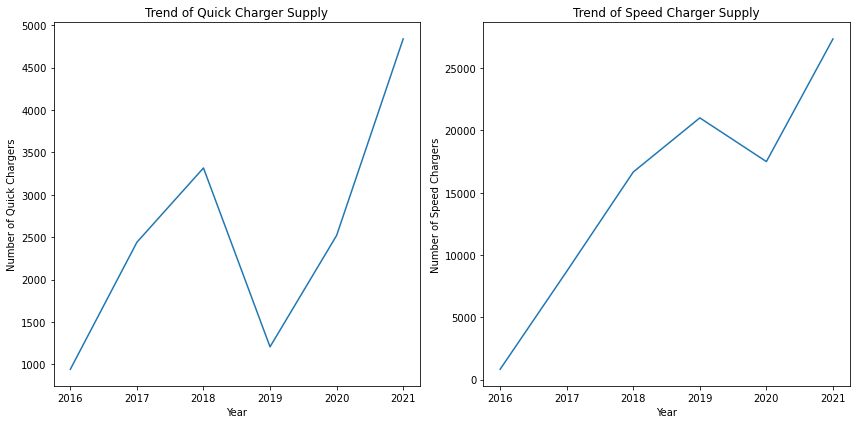

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# 급속충전기 보급 수량 데이터 로드
quick_charger_file = 'Ministry of Environment_Proliferation of Electric Vehicle Quick Chargers_20211231.csv'
quick_charger_df = pd.read_csv(os.path.join(unzip_folder_path, quick_charger_file), encoding='cp949')

# 완속충전기 보급수량 데이터 로드
speed_charger_file = 'Ministry of Environment_Supply of Electric Vehicle Speed Chargers_20211231.csv'
speed_charger_df = pd.read_csv(os.path.join(unzip_folder_path, speed_charger_file), encoding='cp949')

# 시각화
plt.figure(figsize=(12, 6))

# 급속충전기 보급 추세
plt.subplot(1, 2, 1)
sns.lineplot(data=quick_charger_df, x='년도', y='급속충전기 보급 수량')
plt.title('Trend of Quick Charger Supply')
plt.xlabel('Year')
plt.ylabel('Number of Quick Chargers')

# 완속충전기 보급 추세
plt.subplot(1, 2, 2)
sns.lineplot(data=speed_charger_df, x='년도', y='완속충전기 보급수량(단위-기)')
plt.title('Trend of Speed Charger Supply')
plt.xlabel('Year')
plt.ylabel('Number of Speed Chargers')

plt.tight_layout()
plt.show()



급속충전기 보급 추세: 연도별 급속충전기 보급 수량의 변화를 보여준다. 이 그래프를 통해 급속충전기의 보급이 시간에 따라 어떻게 변화하고 있는지 확인할 수 있다.

완속충전기 보급 추세: 연도별 완속충전기 보급수량(단위-기)의 변화를 보여준다. 이 그래프를 통해 완속충전기의 보급이 시간에 따라 어떻게 변화하고 있는지 확인할 수 있다.

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 여기서 'malgun.ttf'는 예시로 사용한 것이며, 실제 한글 폰트 파일로 변경해야 합니다.
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 추가적으로, 축의 음수 부호가 제대로 표시되도록 설정
plt.rcParams['axes.unicode_minus'] = False

# 이제 그래프를 그리는 코드를 사용할 수 있습니다.
# 예시: plt.plot([1, 2, 3, 4])
# plt.show()


### 1. State of the Renewable Energy Industry (General)_2021

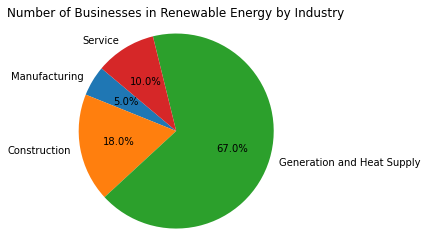

In [91]:
import matplotlib.pyplot as plt

labels = ["Manufacturing", "Construction", "Generation and Heat Supply", "Service"]
sizes = [600, 2144, 8000, 1200]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Number of Businesses in Renewable Energy by Industry")
plt.axis('equal')  # Maintain the pie chart as a circle
plt.show()


#### 신재생에너지 산업별 사업체 수

생성 및 열 공급 : 67%
    
시공: 18%

제조업 : 5%

서비스 : 10%

### 2. 신재생에너지 제조현황_2021(개정)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 파일 경로와 파일 이름
file_path = r'C:\Users\82106\Desktop\데이터분석 프로젝트\빅데이터 공모전\데이터\2. Renewable Energy Manufacturing Status_2021 (Amendment).csv'

# 데이터 불러오기 (cp949 인코딩 사용)
data = pd.read_csv(file_path, encoding='cp949')

# 행 이름 추출
row_names = data.columns

row_names

Index(['Category', '사업체수(개)', '기업체수(개)', '종사자수(명)', '종사자수(명)_고용형태별_상용근로자',
       '종사자수(명)_고용형태별_일용·임시근로자', '종사자수(명)_고용형태별_자영업자·무급가족종사자',
       '종사자수(명)_고용형태별_기타종사자', '종사자수(명)_직무별_사무직', '종사자수(명)_직무별_생산·기술직',
       '종사자수(명)_직무별_연구직', '종사자수(명)_직무별_기타직', '매출액(억원)', '매출액(억원)_내수',
       '매출액(억원)_수출', '매출액(억원)_해외공장', '투자액(억원)'],
      dtype='object')

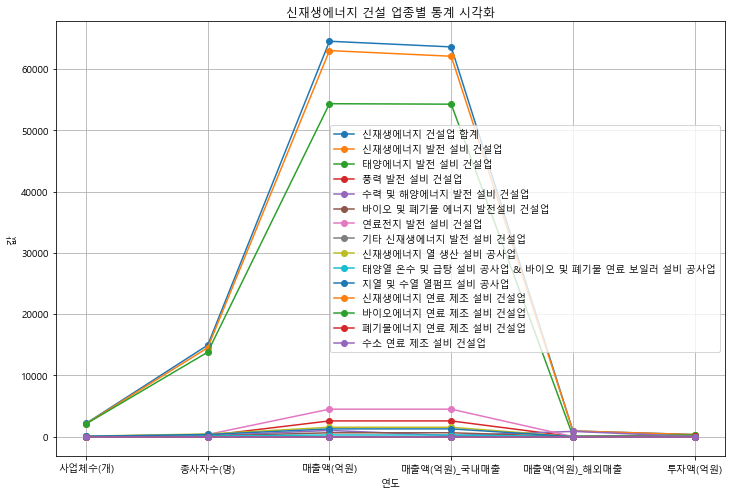

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로와 파일 이름 설정
file_path = r'C:\Users\82106\Desktop\데이터분석 프로젝트\빅데이터 공모전\데이터\3. Status of Renewable Energy Construction Industry_2021 (Amendment).csv'

# CSV 파일 읽기
data = pd.read_csv(file_path, encoding='cp949')

# 필요한 행과 열 선택
selected_columns = ['구분', '사업체수(개)', '종사자수(명)', '매출액(억원)', '매출액(억원)_국내매출', '매출액(억원)_해외매출', '투자액(억원)']
selected_rows = ['신재생에너지 건설업 합계', '신재생에너지 발전 설비 건설업', '태양에너지 발전 설비 건설업', '풍력 발전 설비 건설업',
                 '수력 및 해양에너지 발전 설비 건설업', '바이오 및 폐기물 에너지 발전설비 건설업',
                 '연료전지 발전 설비 건설업', '기타 신재생에너지 발전 설비 건설업',
                 '신재생에너지 열 생산 설비 공사업', '태양열 온수 및 급탕 설비 공사업 & 바이오 및 폐기물 연료 보일러 설비 공사업',
                 '지열 및 수열 열펌프 설비 공사업', '신재생에너지 연료 제조 설비 건설업',
                 '바이오에너지 연료 제조 설비 건설업', '폐기물에너지 연료 제조 설비 건설업', '수소 연료 제조 설비 건설업']

# 데이터 필터링
filtered_data = data[data['구분'].isin(selected_rows)][selected_columns]

# 시각화
plt.figure(figsize=(12, 8))
for row in selected_rows:
    subset = filtered_data[filtered_data['구분'] == row]
    plt.plot(subset.columns[1:], subset.iloc[0, 1:], marker='o', label=row)

plt.xlabel('연도')
plt.ylabel('값')
plt.title('신재생에너지 건설 업종별 통계 시각화')
plt.legend(selected_rows)
plt.grid(True)
plt.show()


### 매출액 순위

1 신재생에너지 건설업 합계

2 신재생에너지 발전 설비 건설업

3 태양에너지 발전 설비 건설업

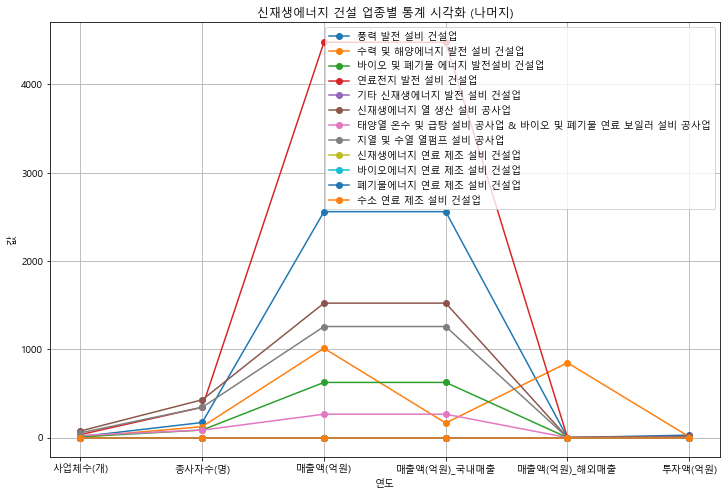

In [124]:
# 나머지 업종 선택
remaining_rows = ['풍력 발전 설비 건설업', '수력 및 해양에너지 발전 설비 건설업', '바이오 및 폐기물 에너지 발전설비 건설업',
                  '연료전지 발전 설비 건설업', '기타 신재생에너지 발전 설비 건설업', '신재생에너지 열 생산 설비 공사업',
                  '태양열 온수 및 급탕 설비 공사업 & 바이오 및 폐기물 연료 보일러 설비 공사업',
                  '지열 및 수열 열펌프 설비 공사업', '신재생에너지 연료 제조 설비 건설업',
                  '바이오에너지 연료 제조 설비 건설업', '폐기물에너지 연료 제조 설비 건설업', '수소 연료 제조 설비 건설업']

# 데이터 필터링
filtered_data_remaining = data[data['구분'].isin(remaining_rows)][selected_columns]

# 시각화
plt.figure(figsize=(12, 8))
for row in remaining_rows:
    subset = filtered_data_remaining[filtered_data_remaining['구분'] == row]
    plt.plot(subset.columns[1:], subset.iloc[0, 1:], marker='o', label=row)

plt.xlabel('연도')
plt.ylabel('값')
plt.title('신재생에너지 건설 업종별 통계 시각화 (나머지)')
plt.legend(remaining_rows)
plt.grid(True)
plt.show()


### 매출액 순위

1.연료전지 발전 설비 건설업

2.풍력발전 설비 건설업 

3.신재생 에너지 열 생산 설비 공사업

### 3. 신재생에너지 건설산업 현황_2021(개정)

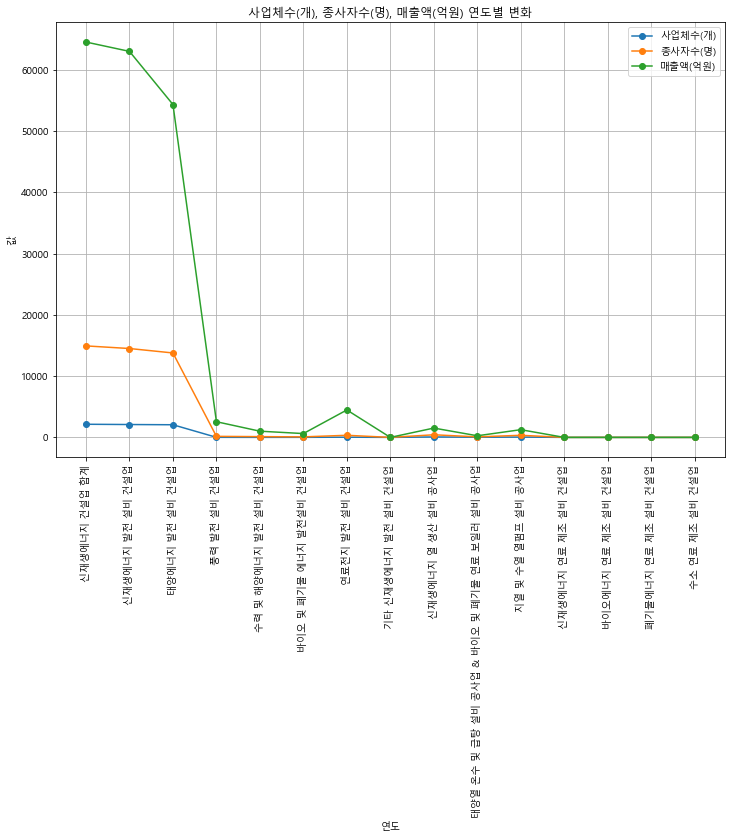

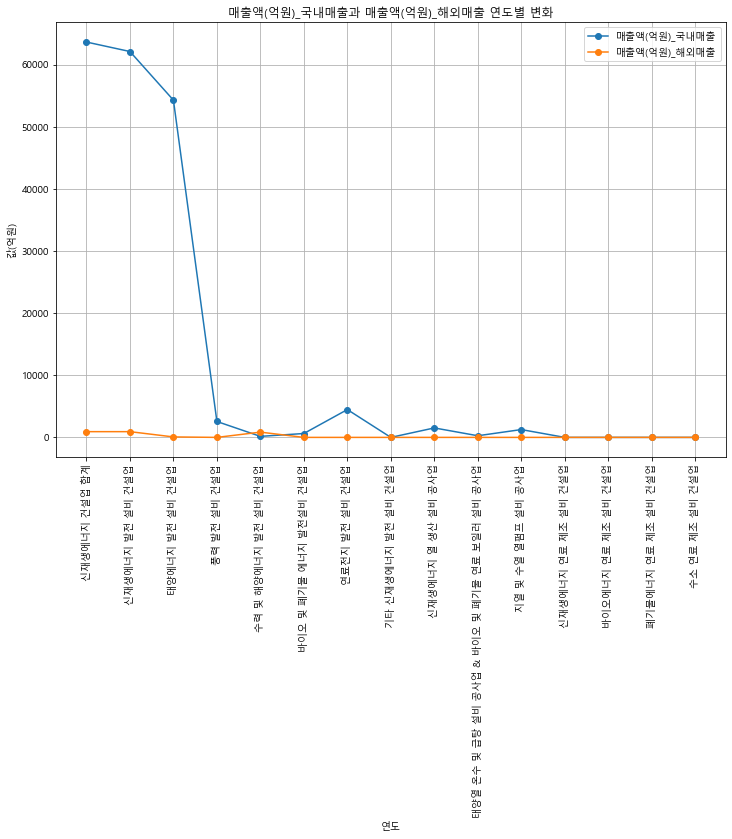

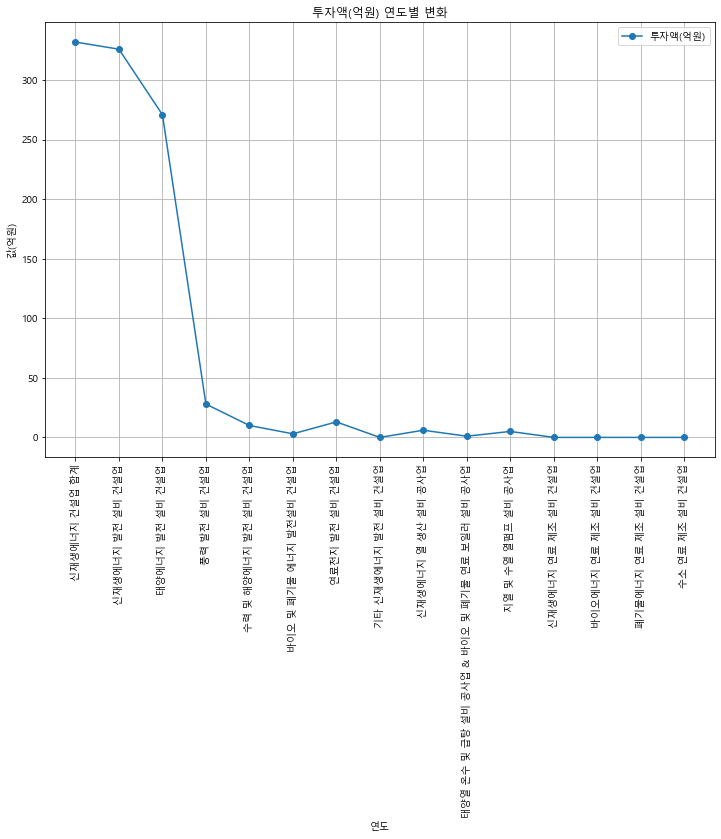

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로와 파일 이름 설정
file_path = r'C:\Users\82106\Desktop\데이터분석 프로젝트\빅데이터 공모전\데이터\3. Status of Renewable Energy Construction Industry_2021 (Amendment).csv'

# CSV 파일 읽기
df = pd.read_csv(file_path, encoding='cp949')

# 그래프 1: 사업체수(개), 종사자수(명), 매출액(억원) 연도별 변화 시각화
plt.figure(figsize=(12, 8))
plt.plot(df['구분'], df['사업체수(개)'], marker='o', label='사업체수(개)')
plt.plot(df['구분'], df['종사자수(명)'], marker='o', label='종사자수(명)')
plt.plot(df['구분'], df['매출액(억원)'], marker='o', label='매출액(억원)')
plt.xlabel('연도')
plt.ylabel('값')
plt.title('사업체수(개), 종사자수(명), 매출액(억원) 연도별 변화')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)

# 그래프 2: 매출액(억원)_국내매출과 매출액(억원)_해외매출 연도별 변화 시각화
plt.figure(figsize=(12, 8))
plt.plot(df['구분'], df['매출액(억원)_국내매출'], marker='o', label='매출액(억원)_국내매출')
plt.plot(df['구분'], df['매출액(억원)_해외매출'], marker='o', label='매출액(억원)_해외매출')
plt.xlabel('연도')
plt.ylabel('값(억원)')
plt.title('매출액(억원)_국내매출과 매출액(억원)_해외매출 연도별 변화')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)

# 그래프 3: 투자액(억원) 연도별 변화 시각화
plt.figure(figsize=(12, 8))
plt.plot(df['구분'], df['투자액(억원)'], marker='o', label='투자액(억원)')
plt.xlabel('연도')
plt.ylabel('값(억원)')
plt.title('투자액(억원) 연도별 변화')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)

plt.show()


### 4. 신재생에너지 보급현황_2021(개정)

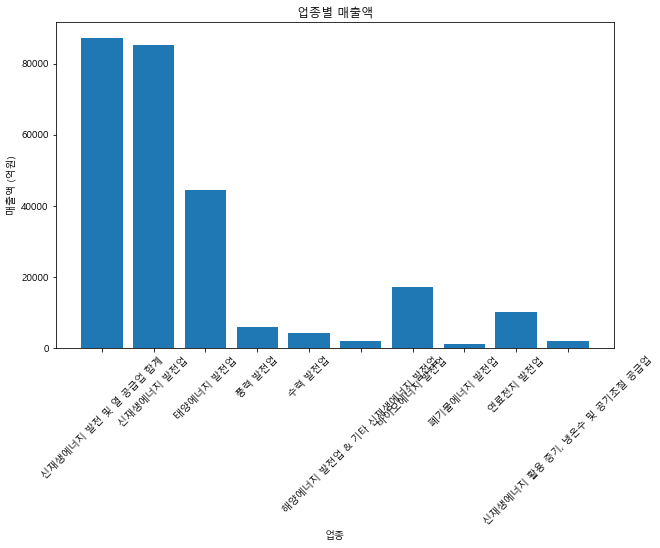

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# 파일 경로
file_path = r'C:\Users\82106\Desktop\데이터분석 프로젝트\빅데이터 공모전\데이터\4. Renewable Energy Supply Status_2021 (Amendment).csv'

# 데이터 로드, 인코딩 지정
df = pd.read_csv(file_path, encoding='cp949')


# 시각화: 막대 그래프로 각 업종별 매출액 시각화
plt.figure(figsize=(10, 6))
plt.bar(df['구분'], df['매출액(억원)'])
plt.xlabel('업종')
plt.ylabel('매출액 (억원)')
plt.xticks(rotation=45)
plt.title('업종별 매출액')
plt.show()


### 신재생 에너지 업종별 매출액

1.신재생 에너지 발전업

2.태양에너지 발전업 

3.바이오 에너지 발전업

4.연료전지 발전업

### 5.신재생에너지 서비스산업 현황_2021

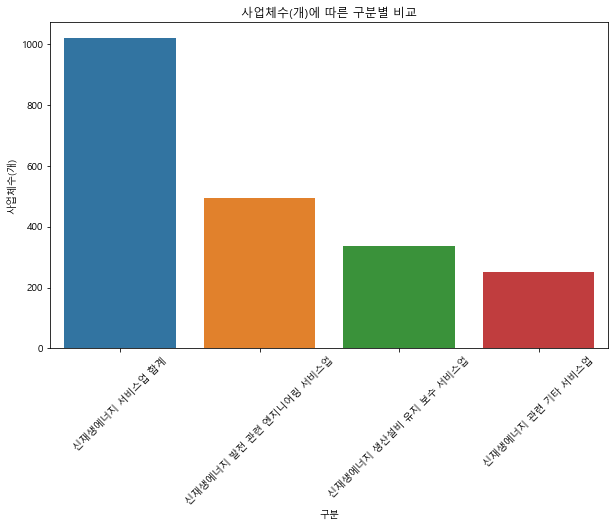

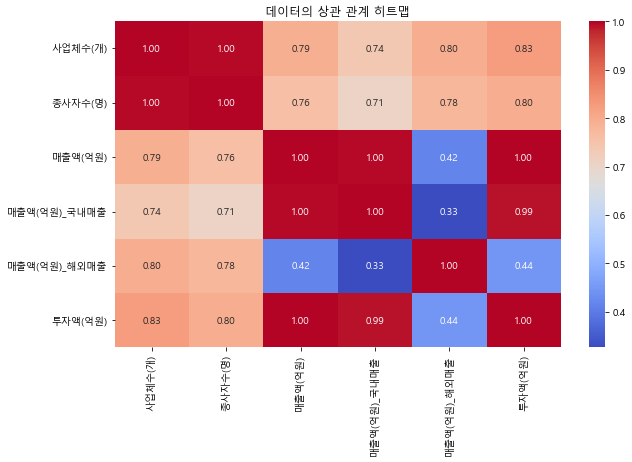

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "C:\\Users\\82106\\Desktop\\데이터분석 프로젝트\\빅데이터 공모전\\데이터\\5. Renewable Energy Service Industry Status_2021.csv"
data = pd.read_csv(file_path, encoding='cp949')

plt.figure(figsize=(10, 6))
sns.barplot(x='구분', y='사업체수(개)', data=data)
plt.title('사업체수(개)에 따른 구분별 비교')
plt.xlabel('구분')
plt.ylabel('사업체수(개)')
plt.xticks(rotation=45)
plt.show()

correlation_matrix = data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('데이터의 상관 관계 히트맵')
plt.show()


사업체는 신재생에너지 발전관련 엔지니어링 사업체가 가장 많았다.

상관관계에서는 투자액과 사업체수의 상관관계로 0.83으로 가장 높았으며 이말은 , 투자액이 많을수록 사업체수도 많았다는 것이다. 

### 한국전력_지역별 전기차 현황정보_20230331

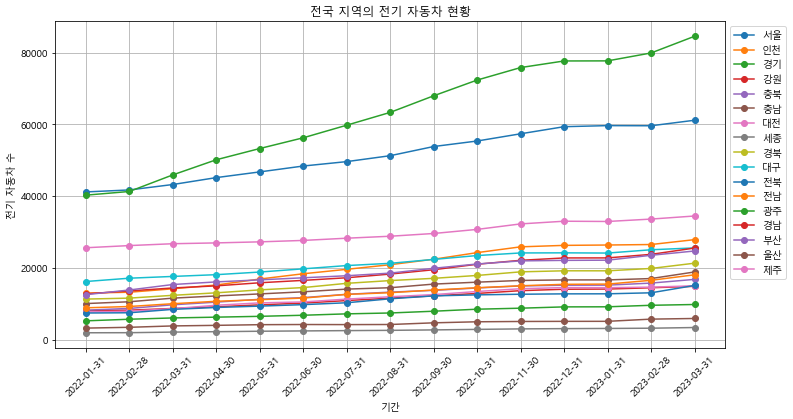

In [155]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "C:\\Users\\82106\\Desktop\\데이터분석 프로젝트\\빅데이터 공모전\\데이터\\KEPCO_Electric Vehicle Status Information by Region_20230331.csv"
data = pd.read_csv(file_path, encoding='cp949')

# 합계 열 제외
data = data.drop(columns=['합계'])


# 모든 지역에 대한 선 그래프 생성
plt.figure(figsize=(12, 6))
for column in data.columns[1:]:
    plt.plot(data['기준일'], data[column], label=column, marker='o')

plt.xlabel('기간')
plt.ylabel('전기 자동차 수')
plt.title('전국 지역의 전기 자동차 현황')
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()
plt.show()


### 전국 지역 전기자동차 현황 순위

1.경기

2.서울

3.제주 

# 한국지역난방공사_신재생에너지 전력생산현황_20230922

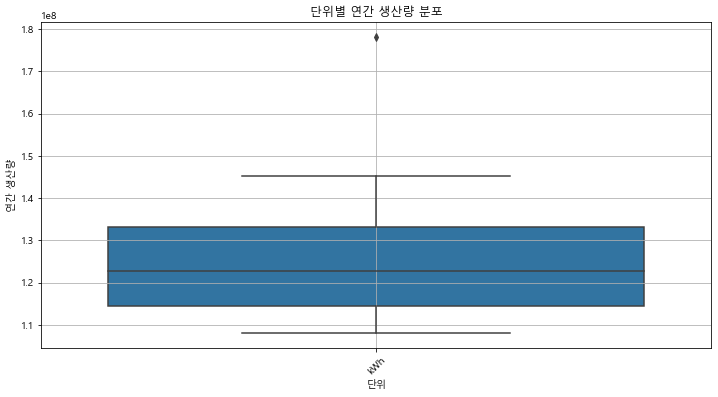

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
file_path = "C:\\Users\\82106\\Desktop\\데이터분석 프로젝트\\빅데이터 공모전\\데이터\\Korea District Heating Corporation_New and renewable energy electricity production status_20230922.csv"
data = pd.read_csv(file_path, encoding='cp949')

# 상자 그림 생성
plt.figure(figsize=(12, 6))
sns.boxplot(x='단위', y='연간생산량', data=data)
plt.xlabel('단위')
plt.ylabel('연간 생산량')
plt.title('단위별 연간 생산량 분포')
plt.xticks(rotation=45)
plt.grid()
plt.show()


신재생 에너지의 전력 연간 생산량은 1.1~ 1.4 kw/h이다.

# 한국전력거래소_신재생에너지 전력거래량_20211201

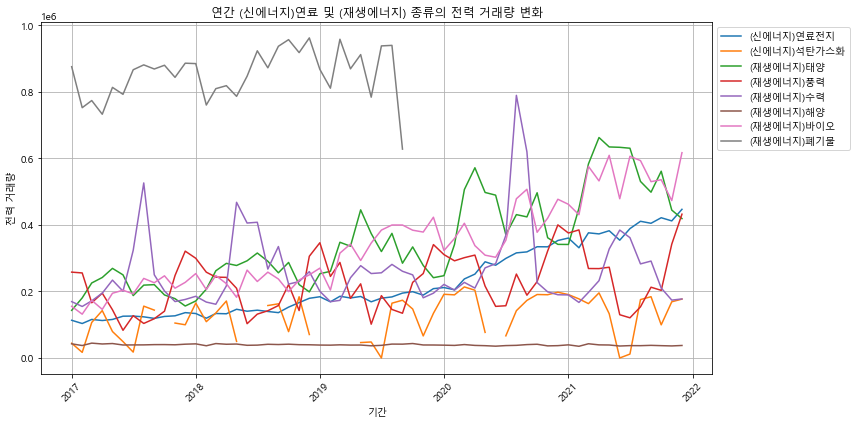

In [167]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "C:\\Users\\82106\\Desktop\\데이터분석 프로젝트\\빅데이터 공모전\\데이터\\Korea Electric Power Exchange_New and Renewable Energy Power Trading Volume_20211201.csv"
data = pd.read_csv(file_path, encoding='cp949')

# 기간을 날짜 형식으로 변환
data['기간'] = pd.to_datetime(data['기간'])

# 그래프 설정
plt.figure(figsize=(12, 6))
plt.xlabel('기간')
plt.ylabel('전력 거래량')
plt.title('연간 (신에너지)연료 및 (재생에너지) 종류의 전력 거래량 변화')

# 각 (신에너지)연료 및 (재생에너지) 종류에 대한 선 그래프 생성
for column in data.columns[1:]:
    plt.plot(data['기간'], data[column], label=column)

# 범례 표시 및 그리드 설정
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()

# 그래프 출력
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


바이오와 태양에너지 , 연료전지 에너지는 전력 거래량에서 꾸준한 우상향을 보여주고 있다.

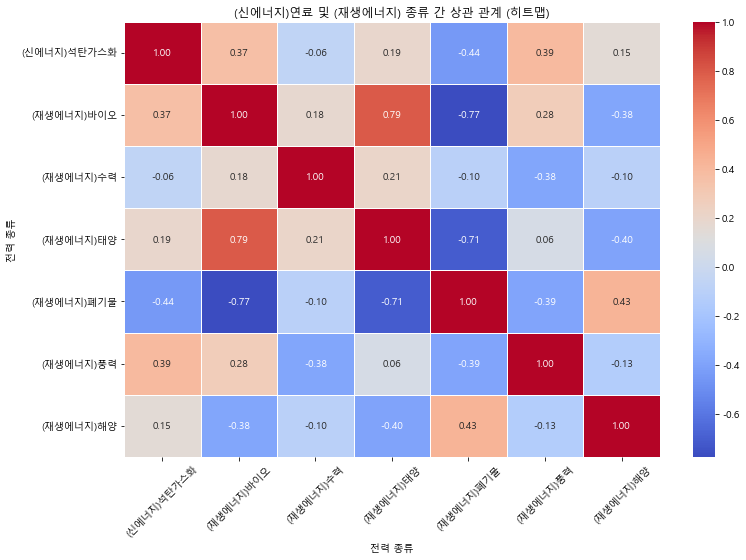

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
file_path = "C:\\Users\\82106\\Desktop\\데이터분석 프로젝트\\빅데이터 공모전\\데이터\\Korea Electric Power Exchange_New and Renewable Energy Power Trading Volume_20211201.csv"
data = pd.read_csv(file_path, encoding='cp949')

# 피벗 테이블 생성
pivot_table = data.pivot_table(index='기간', values=data.columns[2:], aggfunc='sum')

# 상관 행렬 생성
correlation_matrix = pivot_table.corr()

# 히트맵 생성
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.xlabel('전력 종류')
plt.ylabel('전력 종류')
plt.title('(신에너지)연료 및 (재생에너지) 종류 간 상관 관계 (히트맵)')
plt.xticks(rotation=45)
plt.show()


바이오와 태양에너지는 상관관계 계수가 0.79로 상관관계가 높은것으로 나타났다. 

그리고 바이오와 폐기물은 -0.77 로 나타났다.

태양에너지와 바이오재생에너지는 -0.71

# 한국전력거래소_시간별 신재생에너지 거래량_20220331

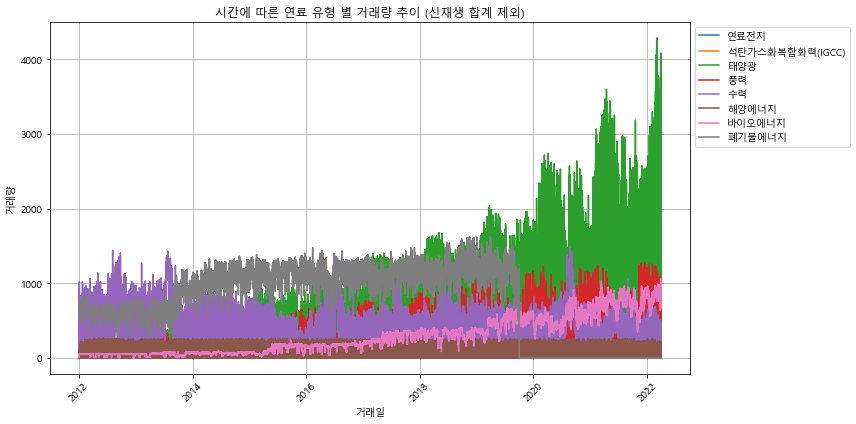

In [169]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "C:\\Users\\82106\\Desktop\\데이터분석 프로젝트\\빅데이터 공모전\\데이터\\Korea Electric Power Exchange_New and renewable energy trading volume by hour_20220331.csv"
data = pd.read_csv(file_path, encoding='cp949')

# 거래일을 날짜 형식으로 변환
data['거래일'] = pd.to_datetime(data['거래일'])

# '신재생 합계' 열 제외
data = data.drop(columns=['신재생 합계'])

# 그래프 설정
plt.figure(figsize=(12, 6))
plt.xlabel('거래일')
plt.ylabel('거래량')
plt.title('시간에 따른 연료 유형 별 거래량 추이 (신재생 합계 제외)')

# 연료 유형에 따른 선 그래프 생성
fuel_types = ['연료전지', '석탄가스화복합화력(IGCC)', '태양광', '풍력', '수력', '해양에너지', '바이오에너지', '폐기물에너지']
for fuel_type in fuel_types:
    plt.plot(data['거래일'], data[fuel_type], label=fuel_type)

# 범례 표시 및 그리드 설정
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid()

# 그래프 출력
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 연료 거래량 순위 

1.태양광 

2.풍력

3.바이오 에너지 

# 한국에너지공단_에너지이용합리화기금지원시설_20230824

C:\Users\82106\AppData\Local\Temp\ipykernel_23296\2779789670.py:16: UserWarning: Glyph 8228 (\N{ONE DOT LEADER}) missing from current font.
  plt.tight_layout()
C:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8228 (\N{ONE DOT LEADER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


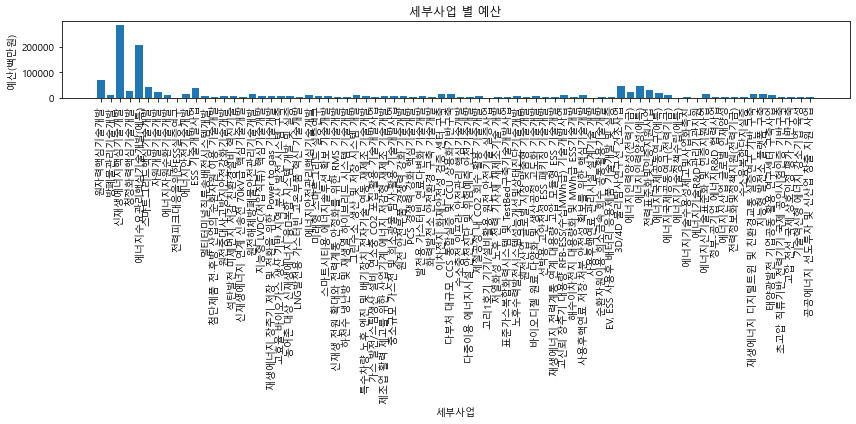

In [172]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "C:\\Users\\82106\\Desktop\\데이터분석 프로젝트\\빅데이터 공모전\\데이터\\Korea Energy Technology Evaluation Institute_Energy Technology Development Statistics_Budget Status_20220901.csv"
data = pd.read_csv(file_path, encoding='UTF-8')
# 막대 그래프 설정
plt.figure(figsize=(12, 6))
plt.bar(data['세부사업'], data['예산(백만원)'])
plt.xlabel('세부사업')
plt.ylabel('예산(백만원)')
plt.title('세부사업 별 예산')

# 그래프 출력
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### 사업별 예산 순위 

1.신재생 핵심기술 개발

2.에너지 수요관리 핵심기술 관리 개발 

3.원자력 핵심기술 개발

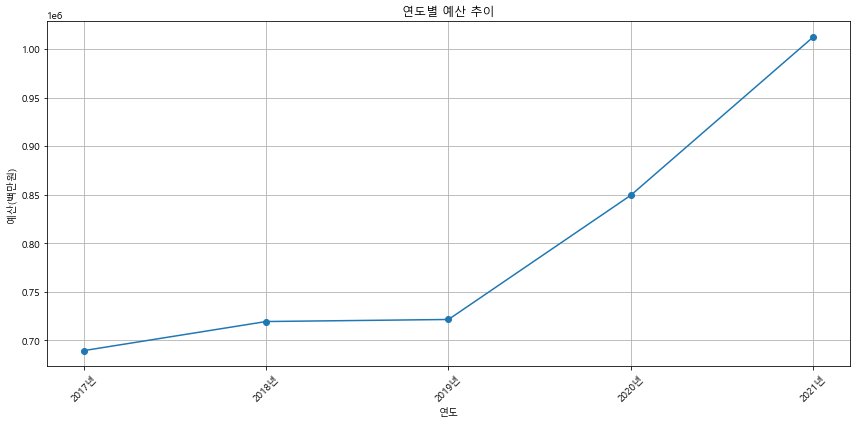

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "C:\\Users\\82106\\Desktop\\데이터분석 프로젝트\\빅데이터 공모전\\데이터\\Korea Energy Technology Evaluation Institute_Energy Technology Development Statistics_Budget Status_20220901.csv"
data = pd.read_csv(file_path, encoding='UTF-8')

# 연도별 예산 데이터 추출
yearly_budget = data.groupby('연도')['예산(백만원)'].sum().reset_index()

# 꺾은 선 그래프 설정
plt.figure(figsize=(12, 6))
plt.plot(yearly_budget['연도'], yearly_budget['예산(백만원)'], marker='o', linestyle='-')
plt.xlabel('연도')
plt.ylabel('예산(백만원)')
plt.title('연도별 예산 추이')

# 그래프 출력
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


연도별 예산추이를 보면 꾸준한 우상향이다

C:\Users\82106\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8228 (\N{ONE DOT LEADER}) missing from current font.
  fig.canvas.draw()
C:\Users\82106\AppData\Local\Temp\ipykernel_23296\1301715741.py:20: UserWarning: Glyph 8228 (\N{ONE DOT LEADER}) missing from current font.
  plt.tight_layout()
C:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8228 (\N{ONE DOT LEADER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


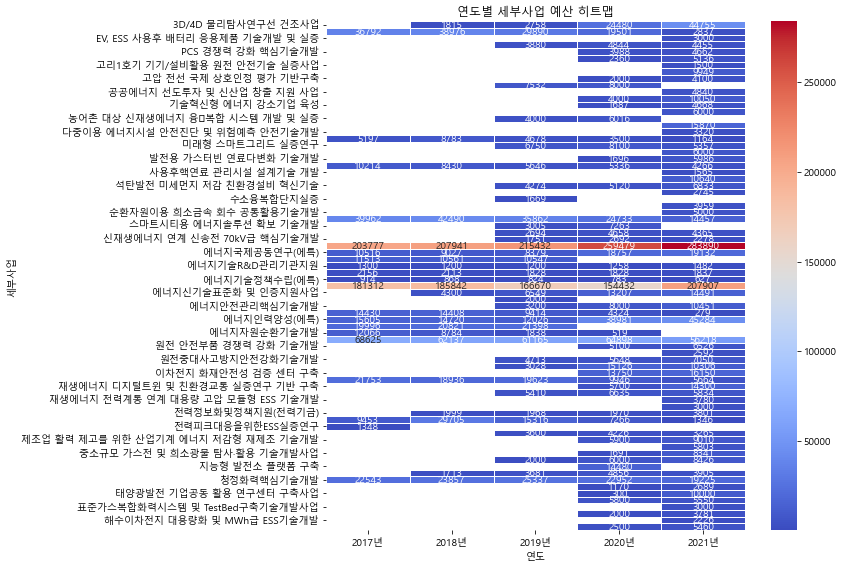

In [175]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = "C:\\Users\\82106\\Desktop\\데이터분석 프로젝트\\빅데이터 공모전\\데이터\\Korea Energy Technology Evaluation Institute_Energy Technology Development Statistics_Budget Status_20220901.csv"
data = pd.read_csv(file_path, encoding='UTF-8')

# 연도와 세부사업에 대한 피벗 테이블 생성
pivot_table = data.pivot_table(index='세부사업', columns='연도', values='예산(백만원)')

# 히트맵 설정
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='g', linewidths=.5)  # 'g'는 일반 숫자 형식
plt.xlabel('연도')
plt.ylabel('세부사업')
plt.title('연도별 세부사업 예산 히트맵')

# 그래프 출력
plt.tight_layout()
plt.show()


# 한국에너지기술평가원_에너지기술개발통계_예산현황_20220901

In [8]:
import pandas as pd
# New file path
file_new = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Korea Energy Technology Evaluation Institute_Energy Technology Development Statistics_Budget Status_20220901.csv'

# Try loading the new file with UTF-8 encoding
try:
    data_new_utf8 = pd.read_csv(file_new, encoding='utf-8')
    load_success_new_utf8 = True
except Exception as e:
    error_new_utf8 = str(e)
    load_success_new_utf8 = False

# Check if the file was loaded successfully or if there was an error with UTF-8 encoding
load_result_new_utf8 = "로드 성공" if load_success_new_utf8 else error_new_utf8
load_result_new_utf8, data_new_utf8.head() if load_success_new_utf8 else "미리보기 불가능"


('로드 성공',
      구분       세부사업     연도  예산(백만원)      데이터기준일
 0  기술개발  원자력핵심기술개발  2017년    68625  2022-09-01
 1  기술개발  원자력핵심기술개발  2018년    62137  2022-09-01
 2  기술개발  원자력핵심기술개발  2019년    61165  2022-09-01
 3  기술개발  원자력핵심기술개발  2020년    64898  2022-09-01
 4  기술개발  원자력핵심기술개발  2021년    56218  2022-09-01)

C:\Users\82106\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8228 (\N{ONE DOT LEADER}) missing from current font.
  fig.canvas.draw()
C:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8228 (\N{ONE DOT LEADER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


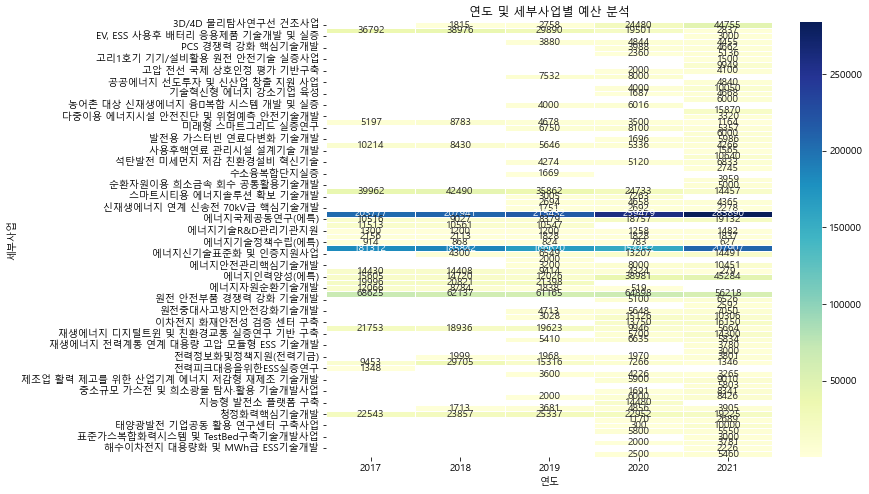

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation for the heatmap
# Convert '연도' to string and remove '년' suffix
data_new_utf8['연도'] = data_new_utf8['연도'].str.replace('년', '')

# Pivot the table to get a matrix form suitable for heatmap
heatmap_data = data_new_utf8.pivot("세부사업", "연도", "예산(백만원)")

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", linewidths=.5, cmap='YlGnBu')
plt.title('연도 및 세부사업별 예산 분석')
plt.xlabel('연도')
plt.ylabel('세부사업')
plt.show()


In [15]:
import pandas as pd

# File paths
file_1 = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Korea Environment Corporation_Korea Environment Corporation_Environmentally Friendly Vehicle Information_Electric Vehicle Purchase Subsidy Information_20181231..csv'
file_2 = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Korea Environment Corporation_Monthly Distribution of Electric Vehicles.csv'
file_3 = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Korea Gas Corporation_Energy consumption by energy source_20201231.csv'

# Load and preview the first file
try:
    data_1 = pd.read_csv(file_1)
except Exception as e:
    error_1 = str(e)

# Check if the file was loaded successfully or if there was an error
loaded_1 = "Loaded successfully" if 'error_1' not in locals() else error_1
loaded_1, data_1.head() if 'data_1' in locals() else "No preview available"


("'utf-8' codec can't decode byte 0xbd in position 1: invalid start byte",
 'No preview available')

In [16]:
# Load the first file with CP949 encoding
try:
    data_1 = pd.read_csv(file_1, encoding='cp949')
    load_success_1 = True
except Exception as e:
    error_1 = str(e)
    load_success_1 = False

# Check if the file was loaded successfully or if there was an error
load_result_1 = "로드 성공" if load_success_1 else error_1
load_result_1, data_1.head() if load_success_1 else "미리보기 불가능"


('로드 성공',
    시도   지역구분   접수방법  민간공고대수    접수대수  출고대수  출고잔여대수  최대 보조금(만원)/승용  \
 0  서울  서울특별시  출고등록순    3944  3944.0  3944       0         1700.0   
 1  부산  부산광역시  촐고등록순     561   561.0   561       0         1700.0   
 2  대구  대구광역시  출고등록순    4206  4733.0  4432    -226         1800.0   
 3  인천  인천광역시    선착순     578   721.0   578       0         1800.0   
 4  광주  광주광역시  출고등록순     536   536.0   536       0         1900.0   
 
    최대 보조금(만원)/초소형  최대 보조금(만원)/화물  최대 보조금(만원)/버스  \
 0           750.0         1650.0            NaN   
 1           656.0         2500.0            NaN   
 2           850.0         1750.0            NaN   
 3           650.0            NaN            NaN   
 4           700.0            NaN            NaN   
 
                                                   비고  
 0  예산소진으로 2018년 전기차 보조금 사업 마감o`18년 보급현황 : 3,944대(...  
 1  ○ 100대는 부산 청춘 드림카 우선지원(주관: 일자리경제정책과) ○ 접수현황:56...  
 2  ※2018년 전기자동차 보급 계획대수 : 4,206대(전기택시, 초소형 포함) ○접...  
 3  ○선정현황 : 578대 -승용: 556대 -초소형: 22대

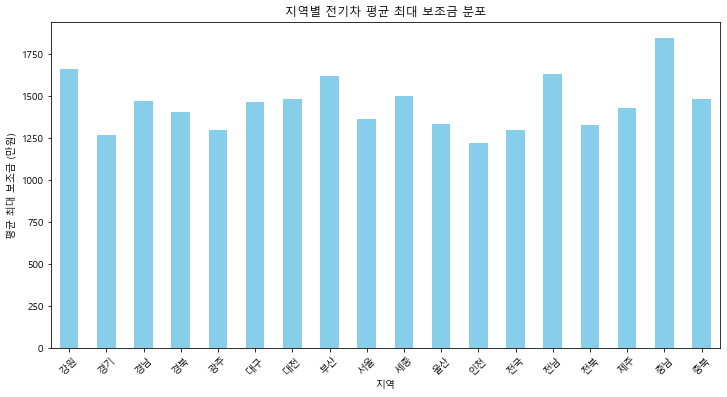

In [17]:
# 1. 지역별 전기차 보조금 분포
# Calculating the average maximum subsidy for each region
subsidy_columns = ['최대 보조금(만원)/승용', '최대 보조금(만원)/초소형', '최대 보조금(만원)/화물', '최대 보조금(만원)/버스']
data_1['평균 최대 보조금'] = data_1[subsidy_columns].mean(axis=1)
average_subsidy_by_region = data_1.groupby('시도')['평균 최대 보조금'].mean()

# Creating a bar chart for average maximum subsidy by region
plt.figure(figsize=(12, 6))
average_subsidy_by_region.plot(kind='bar', color='skyblue')
plt.title('지역별 전기차 평균 최대 보조금 분포')
plt.xlabel('지역')
plt.ylabel('평균 최대 보조금 (만원)')
plt.xticks(rotation=45)
plt.show()


#### 보조금순위

1.충남

2.강원

3.부산,전남

전기차 보급률이 낮은 도시 위주

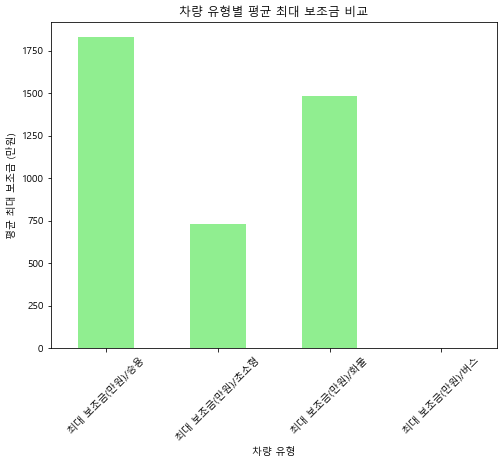

In [18]:
# 2. 차량 유형별 보조금 비교
# Calculating the average maximum subsidy for each vehicle type
average_subsidy_by_type = data_1[subsidy_columns].mean()

# Creating a bar chart for average maximum subsidy by vehicle type
plt.figure(figsize=(8, 6))
average_subsidy_by_type.plot(kind='bar', color='lightgreen')
plt.title('차량 유형별 평균 최대 보조금 비교')
plt.xlabel('차량 유형')
plt.ylabel('평균 최대 보조금 (만원)')
plt.xticks(rotation=45)
plt.show()


#### 차량 유형에 따른 보조금 순위

1.승용차

2.화물차

3.초소형 차

# 한국환경공단_한국환경공단_친환경자동차 정보_전기자동차 구매보조금 정보_20181231

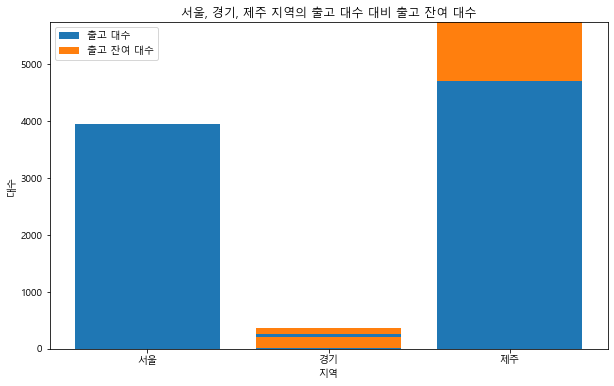

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# 데이터를 로드합니다. 이 부분은 이미 완료하셨을 것으로 가정합니다.
# data_1 = pd.read_csv('your_file_path.csv', encoding='cp949')

# 서울, 경기, 제주 지역 데이터만 필터링합니다.
selected_regions = ['서울', '경기', '제주']
filtered_data = data_1[data_1['시도'].isin(selected_regions)]

# 출고 대수와 출고 잔여 대수를 비교하는 바 차트를 생성합니다.
plt.figure(figsize=(10, 6))
plt.bar(filtered_data['시도'], filtered_data['출고대수'], label='출고 대수')
plt.bar(filtered_data['시도'], filtered_data['출고잔여대수'], bottom=filtered_data['출고대수'], label='출고 잔여 대수')
plt.xlabel('지역')
plt.ylabel('대수')
plt.title('서울, 경기, 제주 지역의 출고 대수 대비 출고 잔여 대수')
plt.legend()
plt.show()


# 한국환경공단_전기자동차 월별 보급현황

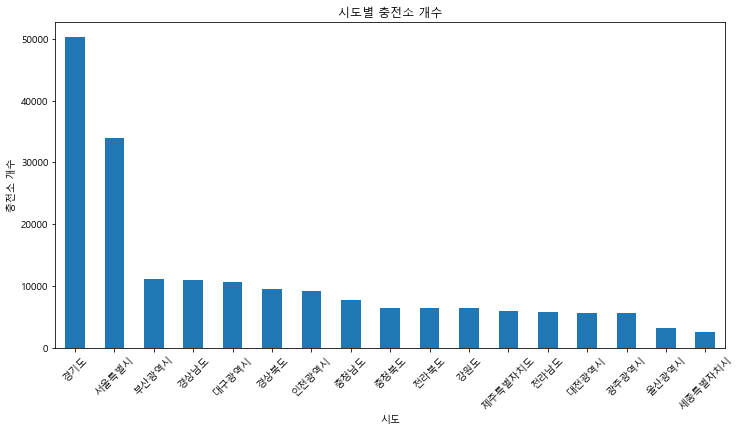

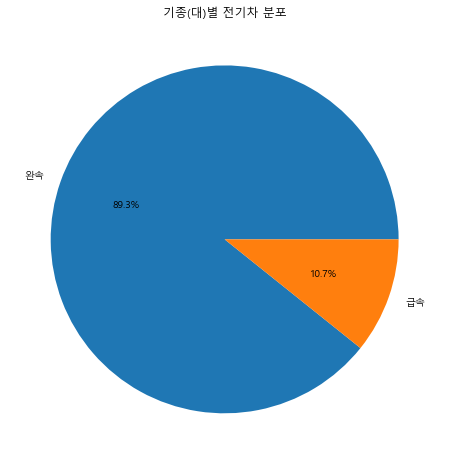

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (인코딩을 'cp949'로 설정)
data = pd.read_csv(r'C:\Users\82106\Desktop\데이터분석 프로젝트\빅데이터 공모전\데이터\Korea Environment Corporation_Monthly Distribution of Electric Vehicles.csv', encoding='cp949')

# 막대 그래프 (시도별 충전소 개수)
plt.figure(figsize=(12, 6))
data['시도'].value_counts().plot(kind='bar')
plt.title('시도별 충전소 개수')
plt.xlabel('시도')
plt.ylabel('충전소 개수')
plt.xticks(rotation=45)
plt.show()

# 원 그래프 (기종(대)별 전기차 분포)
plt.figure(figsize=(8, 8))
data['기종(대)'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('기종(대)별 전기차 분포')
plt.ylabel('')
plt.show()


### 시도별 충전개수 순위

1.경기도

2,서울

3.부산,경남


완속 90% , 급속10%

In [4]:
import pandas as pd

# Load the first dataset: Korea Gas Corporation Energy consumption
file_path_gas = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Korea Gas Corporation_Energy consumption by energy source_20201231.csv'

# Try opening the file with 'cp949' encoding, commonly used for Korean text
try:
    gas_data = pd.read_csv(file_path_gas, encoding='cp949')
except UnicodeDecodeError:
    # If cp949 doesn't work, try with 'euc-kr'
    gas_data = pd.read_csv(file_path_gas, encoding='euc-kr')

# Display the first few rows of the dataset
gas_data.head()


,연도,에너지용도로 구매 및 소비된 비재생 에너지 연료(MWh),비재생 구매 전력(MWh),스팀-난방-냉방 및 기타 에너지 구매(MWh),재생에너지 구매 또는 생산(MWh),총 비재생 에너지 소비(MWh),총 에너지 소비 비용(억원)
0,2016,902222,765337,18333,2059,1686666,1251
1,2017,1440833,769532,13611,3249,2223976,1419
2,2018,1813858,830694,14633,1425,2659186,1736
3,2019,1368333,811414,12778,2166,2192525,1547
4,2020,1777673,830706,16147,3199,2608379,1347


In [5]:
# Load the second dataset: Korea Transportation Safety Authority Hydrogen Electric Vehicle Registration Status
file_path_hydrogen = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Korea Transportation Safety Authority_Hydrogen Electric Vehicle Registration Status_20230725.csv'

# Try opening the file with 'cp949' encoding
try:
    hydrogen_vehicle_data = pd.read_csv(file_path_hydrogen, encoding='cp949')
except UnicodeDecodeError:
    # If cp949 doesn't work, try with 'euc-kr'
    hydrogen_vehicle_data = pd.read_csv(file_path_hydrogen, encoding='euc-kr')

# Display the first few rows of the dataset
hydrogen_vehicle_data.head()


,지역,승용,승합,화물,총합계
0,강원,2660,NaN,1.0,2661
1,경기,7168,11.0,1.0,7180
2,경남,2599,59.0,NaN,2658
3,경북,362,NaN,NaN,362
4,광주,1192,22.0,NaN,1214


In [6]:
# Load the third dataset: Ministry of Environment Proliferation of Electric Vehicle Quick Chargers
file_path_chargers = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Ministry of Environment_Proliferation of Electric Vehicle Quick Chargers_20211231.csv'

# Try opening the file with 'cp949' encoding
try:
    ev_charger_data = pd.read_csv(file_path_chargers, encoding='cp949')
except UnicodeDecodeError:
    # If cp949 doesn't work, try with 'euc-kr'
    ev_charger_data = pd.read_csv(file_path_chargers, encoding='euc-kr')

# Display the first few rows of the dataset
ev_charger_data.head()


,년도,급속충전기 보급 수량,설명
0,2016,943,2016년이전 보급수 포함
1,2017,2441,2017년 단년도
2,2018,3317,2018년 단년도
3,2019,1208,2019년 단년도
4,2020,2521,2020년 단년도


# 한국가스공사_에너지원별 에너지 소비량_20201231

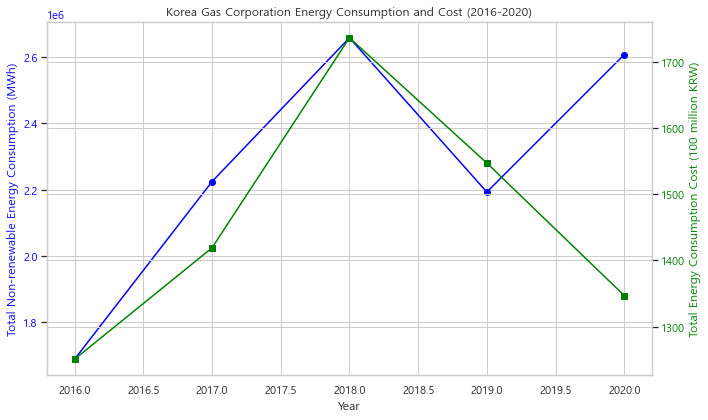

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting total non-renewable energy consumption on the first y-axis
ax1.set_title('Korea Gas Corporation Energy Consumption and Cost (2016-2020)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Non-renewable Energy Consumption (MWh)', color='blue')
ax1.plot(gas_data['연도'], gas_data['총 비재생 에너지 소비(MWh)'], label='Total Non-renewable Energy Consumption (MWh)', color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Creating a second y-axis for total energy consumption cost
ax2 = ax1.twinx()
ax2.set_ylabel('Total Energy Consumption Cost (100 million KRW)', color='green')
ax2.plot(gas_data['연도'], gas_data['총 에너지 소비 비용(억원)'], label='Total Energy Consumption Cost (100 million KRW)', color='green', marker='s')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()
plt.show()


### 총 비재생 에너지 소비(MWh) (왼쪽 파란색 y축):

2016년부터 2020년까지의 기간 동안 비재생 에너지 소비량은 일정한 증감 패턴을 보입니다. 특히 2018년에는 소비량이 크게 증가했으며, 이는 증가된 에너지 수요 또는 생산 활동의 증가를 반영할 수 있습니다.

2019년에 비재생 에너지 소비량이 감소했으나, 2020년에 다시 증가하는 추세를 보입니다. 이러한 변화는 시장 상황, 에너지 정책, 기술적 진보 등 다양한 요인에 의해 영향을 받을 수 있습니다.

### 총 에너지 소비 비용(억원) (오른쪽 녹색 y축):

총 에너지 소비 비용은 2016년부터 2019년까지 증가하는 추세를 보였으며, 2020년에는 다소 감소했습니다.

에너지 소비량과 비용 사이에는 직접적인 비례 관계가 항상 성립하지는 않습니다. 이는 에너지 가격, 세금, 환율 등 다른 경제적 요인에 의해 비용이 변동될 수 있기 때문입니다. 예를 들어, 에너지 가격이 상승하면 동일한 양의 에너지를 소비하더라도 비용이 증가할 수 있습니다

# 한국교통안전공단_수소전기차 등록현황_20230725

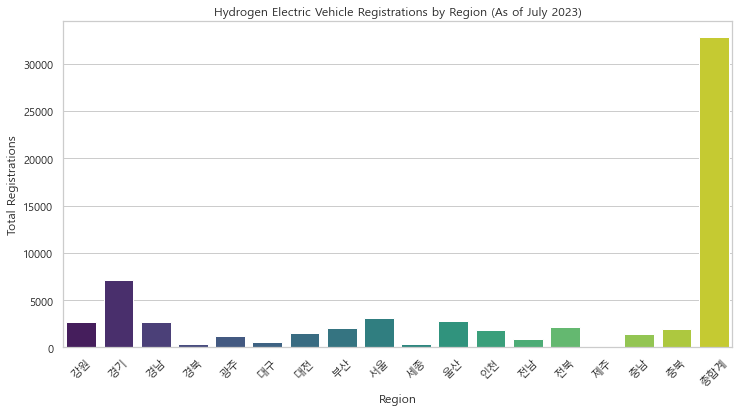

In [9]:
# Plotting Korea Transportation Safety Authority Hydrogen Electric Vehicle Registration Status data
plt.figure(figsize=(12, 6))

# Creating a bar plot for total hydrogen electric vehicle registrations by region
sns.barplot(x='지역', y='총합계', data=hydrogen_vehicle_data, palette='viridis')

plt.title('Hydrogen Electric Vehicle Registrations by Region (As of July 2023)')
plt.xlabel('Region')
plt.ylabel('Total Registrations')
plt.xticks(rotation=45)
plt.show()


지역별 등록 대수의 차이: 그래프에서 볼 수 있듯이, 수소전기차의 등록 대수는 지역마다 큰 차이를 보인다. 일부 지역은 수소전기차의 등록 대수가 상당히 높은 반면, 다른 지역에서는 상대적으로 적다. 이는 각 지역의 인프라, 경제 활동, 환경 정책, 그리고 수소 연료 공급망의 발달 정도에 따라 달라질 수 있다.

수소전기차의 인기와 확산 정도: 특정 지역에서 높은 등록 대수는 그 지역에서 수소전기차에 대한 관심과 수용도가 높음을 나타낼 수 있다. 이는 수소전기차에 대한 정부의 보조금 정책, 충전 인프라의 구축, 그리고 대중의 환경에 대한 인식 변화 등 여러 요인의 영향을 받을 수 있다.

지역별 수소 인프라 개발 상황: 수소전기차의 등록 대수는 해당 지역에서 수소 연료 공급망과 충전 인프라가 얼마나 잘 개발되었는지를 반영할 수 있다. 충전소의 접근성과 편의성은 수소전기차 보급에 큰 영향을 미칠 수 있다.

미래 전략 개발에 대한 시사점: 이 데이터는 수소전기차와 관련된 미래 정책 및 인프라 개발 전략을 수립하는 데 중요한 정보를 제공할 수 있다. 예를 들어, 수소전기차 등록 대수가 적은 지역에는 인프라 개선이나 인센티브 제공 등을 통해 수소전기차의 보급을 촉진할 수 있다.

# 환경부_전기차 급속충전기 보급_20211231

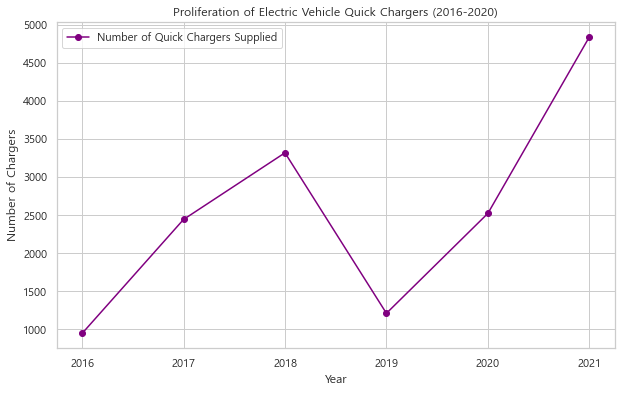

In [10]:
# Plotting Ministry of Environment Proliferation of Electric Vehicle Quick Chargers data
plt.figure(figsize=(10, 6))

# Plotting the number of quick chargers supplied each year
plt.plot(ev_charger_data['년도'], ev_charger_data['급속충전기 보급 수량'], label='Number of Quick Chargers Supplied', marker='o', color='purple')

plt.title('Proliferation of Electric Vehicle Quick Chargers (2016-2020)')
plt.xlabel('Year')
plt.ylabel('Number of Chargers')
plt.legend()
plt.xticks(ev_charger_data['년도'])
plt.show()


보급 수량의 증가 추세: 2016년부터 2020년까지 전기차 급속충전기의 보급 수량이 전반적으로 증가하는 추세를 보인다. 이는 전기차에 대한 수요 증가와 함께 전기차 충전 인프라의 확장을 반영한다.

연도별 변동성: 그래프에서 보이는 연도별 변동성은 여러 요인에 의해 발생할 수 있다. 예를 들어, 정부 정책, 보조금 프로그램, 기술 발전, 그리고 전기차 시장의 전반적인 성장이 보급률에 영향을 줄 수 있다. 특히 2018년에는 상당한 증가가 있었으며, 이는 정부의 지원 정책이나 시장의 활성화와 관련이 있을 수 있다.

인프라 확장의 중요성: 지속적인 충전기 보급 증가는 전기차 사용자들에게 충전 편의성을 제공하여 전기차의 보급을 촉진하는 중요한 요소다. 충분한 충전 인프라는 전기차 구매 결정에 있어 중요한 고려사항이 될 수 있으며, 이는 전기차의 대중화와 환경 보호에 기여할 수 있다.

미래 전략 및 정책 수립에 대한 시사점: 이러한 데이터는 전기차 및 관련 인프라에 대한 미래 투자와 정책 결정에 중요한 근거를 제공할 수 있다. 특히 충전 인프라의 지속적인 확장과 개선은 전기차 보급을 더욱 가속화하고 친환경 교통 수단으로의 전환을 지원할 수 있다.

In [12]:
# Re-importing pandas as the code execution state was reset
import pandas as pd

# Load the first dataset: Ministry of Environment Supply of Electric Vehicle Speed Chargers
file_path_ev_chargers = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Ministry of Environment_Supply of Electric Vehicle Speed Chargers_20211231.csv'

# Try opening the file with 'cp949' encoding
try:
    ev_chargers_data = pd.read_csv(file_path_ev_chargers, encoding='cp949')
except UnicodeDecodeError:
    # If cp949 doesn't work, try with 'euc-kr'
    ev_chargers_data = pd.read_csv(file_path_ev_chargers, encoding='euc-kr')

# Display the first few rows of the dataset
ev_chargers_data.head()


,년도,완속충전기 보급수량(단위-기),설명
0,2016,828,2016년12월 31일까지 설치 현황
1,2017,8684,2017 단년도
2,2018,16662,2018 단년도
3,2019,21008,2019 단년도
4,2020,17499,2020 단년도


In [13]:
# Load the second dataset: Ministry of Trade, Industry and Energy Energy General Survey Electric Vehicle Survey
file_path_ev_survey = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Ministry of Trade, Industry and Energy_Energy General Survey Electric Vehicle Survey_2017.xlsx'

# Read the Excel file
ev_survey_data = pd.read_excel(file_path_ev_survey)

# Display the first few rows of the dataset
ev_survey_data.head()


,Unnamed: 0,차량정보,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 90,Unnamed: 91,Ⅴ. 운전자 인적사항,(제외),Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99
0,NaN,1. 보유차종,1-1. PHEV:연료,2. 차량번호(제외),2-1. 차량등록형태,3. 제조회사,4. 모델명,5. 차량출고연도,5-1. 차량 출고년월_연도,5-1. 차량 출고년월_월,...,4-2-3. (1) 두번째 차량,4-3. 추후 구매 의향 차량,5-1. 운전경력,5-1. 운전경력,5-2. 운전자 연령,5-1. 운전경력,5-3. 운전자 거주형태,5-4. 운전자 직업,5-4. 운전자 직업,5-5. 월평균 총소득
1,NaN,1. 전기자동차\n2. 플러그인하이브리드,1. 전기+휘발유\n2. 전기+경유,NaN,1. 개인\n2. 회사/학원/정부/공공기관,원자료,원자료,1. 2016년 12월 이전\n2. 2017년 1월 이후,NaN,NaN,...,"[용도]\n1. 출퇴근용\n2. 사업용\n3. 가사, 레저 및 기타",1. 일반 내연기관차\n2. 하이브리드차\n3. 플러그인하이브리드차\n4. 전기자동...,NaN,1. 10년 미만\n2. 20년 미만\n3. 30년 미만\n4. 30년 이상,NaN,1. 10대\n2. 20대\n3. 30대\n4. 40대\n5. 50대\n6. 60대,1. 아파트\n2. 다세대/연립주택\n3. 오피스텔\n4. 단독주택,1. 관리자\n2. 전문가 및 관련 종사자\n3. 사무 종사자\n4. 서비스 종사자...,기타,"① 100만원 미만(연1,200만원 미만) \n② 100∼200만원 미만(연1,2..."
2,no.,S1,S1_1,S2,S2_1,S3,S4,S5,S5_1(년),S5_1(월),...,D2_2_4,D3,E1,E1re,E2,E2re,E3,E4,E4(기타),E5
3,1,1,NaN,NaN,1,쉐보레,BOLT,1,2016,8,...,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1,NaN,NaN,1,닛산,리프,1,2015,2,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Load the third dataset: Ministry of Trade, Industry and Energy Related to Power Supply
file_path_power_supply = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Ministry of Trade, Industry and Energy_Related to Power Supply_20211231.csv'

# Try opening the file with 'cp949' encoding
try:
    power_supply_data = pd.read_csv(file_path_power_supply, encoding='cp949')
except UnicodeDecodeError:
    # If cp949 doesn't work, try with 'euc-kr'
    power_supply_data = pd.read_csv(file_path_power_supply, encoding='euc-kr')

# Display the first few rows of the dataset
power_supply_data.head()


,연도,주택용(원_kWh),일반용(원_kWh),산업용(원_kWh),교육용(원_kWh),농사용(원_kWh),가로등(원_kWh)
0,1981,74.6,62.4,0.0,0.0,0.0,78.2
1,1982,75.2,68.8,0.0,0.0,0.0,90.9
2,1983,73.3,66.5,0.0,0.0,0.0,85.0
3,1984,73.3,66.1,0.0,0.0,0.0,84.4
4,1985,73.4,66.6,0.0,0.0,0.0,83.2


In [15]:
# Load the fourth dataset: Power usage by city, county, and district
file_path_power_usage = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Power usage by city, county, and district (for posting on the website)_202107.xlsx'

# Read the Excel file
power_usage_data = pd.read_excel(file_path_power_usage)

# Display the first few rows of the dataset
power_usage_data.head()


,시군구별 계약종별별 전력사용량,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(단위 : kWh)
1,연도,시도,시군구,계약종별,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
2,2021,서울특별시,종로구,주택용,25471662,23888545,20316994,20139886,19260662,21028845,26187114,0,0,0,0,0
3,2021,서울특별시,종로구,일반용,113082168,103460106,90283166,84892275,82623201,95379420,111593855,0,0,0,0,0
4,2021,서울특별시,종로구,교육용,10072542,9169051,7446466,6761511,6071807,7468499,8634914,0,0,0,0,0


# 환경부_전기차 급속충전기 보급_20211231

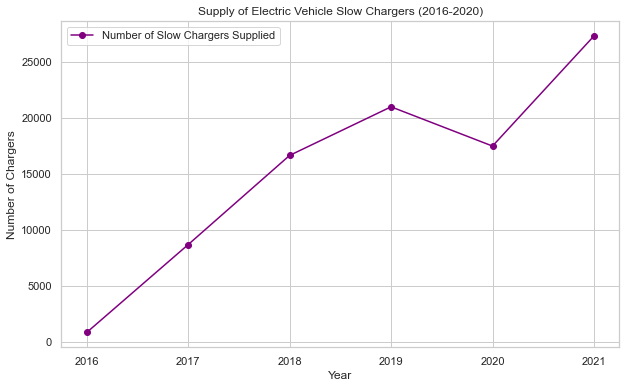

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plots
sns.set(style="whitegrid")

# Plotting Ministry of Environment Supply of Electric Vehicle Speed Chargers data
plt.figure(figsize=(10, 6))

# Plotting the number of slow chargers supplied each year
plt.plot(ev_chargers_data['년도'], ev_chargers_data['완속충전기 보급수량(단위-기)'], label='Number of Slow Chargers Supplied', marker='o', color='purple')

plt.title('Supply of Electric Vehicle Slow Chargers (2016-2020)')
plt.xlabel('Year')
plt.ylabel('Number of Chargers')
plt.legend()
plt.xticks(ev_chargers_data['년도'])
plt.show()


완속충전기 보급은 꾸준한 상승세 이다.

# 산업통상자원부_에너지일반조사 전기자동차조사_2017

C:\Users\82106\AppData\Local\Temp\ipykernel_16904\73035248.py:27: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  plt.tight_layout()
C:\Users\82106\AppData\Local\Temp\ipykernel_16904\73035248.py:27: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  plt.tight_layout()
C:\Users\82106\AppData\Local\Temp\ipykernel_16904\73035248.py:27: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  plt.tight_layout()
C:\Users\82106\AppData\Local\Temp\ipykernel_16904\73035248.py:27: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  plt.tight_layout()
C:\Users\82106\AppData\Local\Temp\ipykernel_16904\73035248.py:27: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  plt.tight_layout()
C:\Users\82106\AppData\Local\Temp\ipykernel_16904\73035248.py:27: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
C:\Users\821

C:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49744 (\N{HANGUL SYLLABLE SWE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\82106\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\82106\anaconda3\l

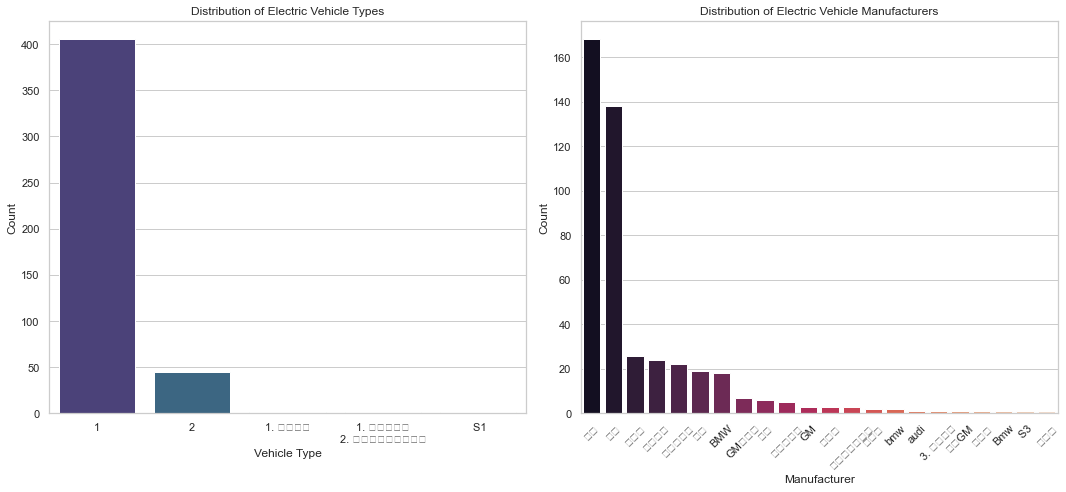

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# For the Electric Vehicle Survey data, let's visualize the distribution of electric vehicle types and manufacturers
# Extracting relevant columns for visualization
ev_types = ev_survey_data['차량정보'].value_counts()
ev_manufacturers = ev_survey_data['Unnamed: 5'].value_counts()

# Setting up the matplotlib figure
plt.figure(figsize=(15, 7))

# Plotting electric vehicle types
plt.subplot(1, 2, 1)
sns.barplot(x=ev_types.index, y=ev_types.values, palette="viridis")
plt.title('Distribution of Electric Vehicle Types')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')

# Plotting electric vehicle manufacturers
plt.subplot(1, 2, 2)
sns.barplot(x=ev_manufacturers.index, y=ev_manufacturers.values, palette="rocket")
plt.title('Distribution of Electric Vehicle Manufacturers')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# 산업통상자원부_전원공급관련_20211231

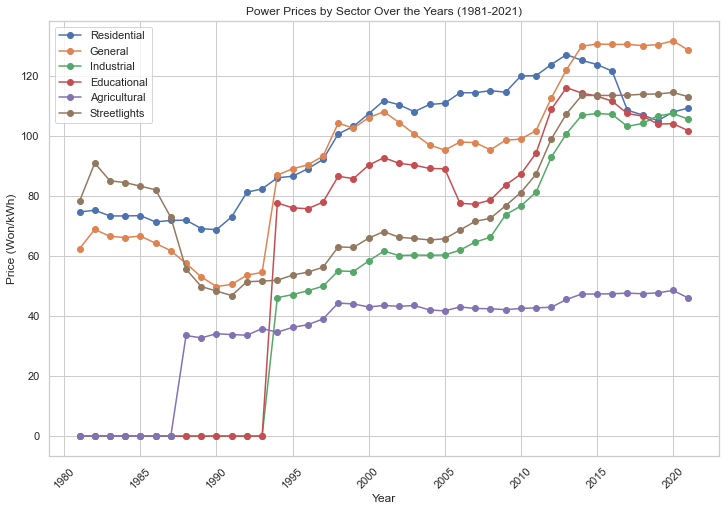

In [17]:
# Plotting Ministry of Trade, Industry and Energy Related to Power Supply data
plt.figure(figsize=(12, 8))

# Plotting power prices for different sectors over the years
plt.plot(power_supply_data['연도'], power_supply_data['주택용(원_kWh)'], label='Residential', marker='o')
plt.plot(power_supply_data['연도'], power_supply_data['일반용(원_kWh)'], label='General', marker='o')
plt.plot(power_supply_data['연도'], power_supply_data['산업용(원_kWh)'], label='Industrial', marker='o')
plt.plot(power_supply_data['연도'], power_supply_data['교육용(원_kWh)'], label='Educational', marker='o')
plt.plot(power_supply_data['연도'], power_supply_data['농사용(원_kWh)'], label='Agricultural', marker='o')
plt.plot(power_supply_data['연도'], power_supply_data['가로등(원_kWh)'], label='Streetlights', marker='o')

plt.title('Power Prices by Sector Over the Years (1981-2021)')
plt.xlabel('Year')
plt.ylabel('Price (Won/kWh)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


연도별 부문별 전력 가격(1981-2021)

2021년 
1위 일반용

2위 가로등

3위 주택용

4위 산업용

5위 교육용

6위 농업용

일반용은 꾸준히 증가세를 보이고 있으며, 주거용은 2013년 부터 하락세로 나오고있다. 교육용도 2013년 부터 꾸준히 하락세이며, 산업용도 2013년까지 꾸준히 증가하다가 동결및 하락을 보여주고있다.

# 시·군·구별 전력 사용량(홈페이지 게시용)_202107

In [44]:
import pandas as pd

# Load the Excel file
file_path = 'C:/Users/82106/Desktop/데이터분석 프로젝트/빅데이터 공모전/데이터/Power usage by city, county, and district (for posting on the website)_202107.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe
data.head()


,시군구별 계약종별별 전력사용량,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(단위 : kWh)
1,연도,시도,시군구,계약종별,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
2,2021,서울특별시,종로구,주택용,25471662,23888545,20316994,20139886,19260662,21028845,26187114,0,0,0,0,0
3,2021,서울특별시,종로구,일반용,113082168,103460106,90283166,84892275,82623201,95379420,111593855,0,0,0,0,0
4,2021,서울특별시,종로구,교육용,10072542,9169051,7446466,6761511,6071807,7468499,8634914,0,0,0,0,0


In [45]:
# Re-loading the Excel file with correct column names
data_with_correct_columns = pd.read_excel(file_path, header=1)

# Displaying the first few rows of the dataframe with correct column names
data_with_correct_columns.head()


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,(단위 : kWh)
0,연도,시도,시군구,계약종별,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
1,2021,서울특별시,종로구,주택용,25471662,23888545,20316994,20139886,19260662,21028845,26187114,0,0,0,0,0
2,2021,서울특별시,종로구,일반용,113082168,103460106,90283166,84892275,82623201,95379420,111593855,0,0,0,0,0
3,2021,서울특별시,종로구,교육용,10072542,9169051,7446466,6761511,6071807,7468499,8634914,0,0,0,0,0
4,2021,서울특별시,종로구,산업용,6243796,6435682,5950803,6422580,5661896,5860405,6473303,0,0,0,0,0


In [46]:
# Renaming columns correctly
data_with_correct_columns.columns = ['Year', 'Province', 'City', 'ContractType', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Dropping the first row which is now a duplicate of the column names
data_with_correct_columns = data_with_correct_columns.drop(0)

# Converting data types
data_with_correct_columns['Year'] = pd.to_numeric(data_with_correct_columns['Year'], errors='coerce')
for month in data_with_correct_columns.columns[4:]:
    data_with_correct_columns[month] = pd.to_numeric(data_with_correct_columns[month], errors='coerce')

# Aggregating data
# 1. Total power usage by Province
total_power_by_province_corrected = data_with_correct_columns.groupby('Province').sum().sum(axis=1).sort_values(ascending=False)

# 2. Power usage by contract type
contract_types_corrected = data_with_correct_columns['ContractType'].unique()
power_by_contract_type_corrected = data_with_correct_columns.groupby('ContractType').sum().sum(axis=1)[contract_types_corrected]

# 3. Monthly power usage for some major cities
major_provinces_corrected = ['서울특별시', '부산광역시', '대구광역시', '인천광역시']
monthly_power_major_cities_corrected = data_with_correct_columns[data_with_correct_columns['Province'].isin(major_provinces_corrected)].groupby(['Year', 'Province']).sum()

total_power_by_province_corrected, power_by_contract_type_corrected, monthly_power_major_cities_corrected.head()


(Province
 경기도        153851641160
 충청남도        56426662738
 서울특별시       53935202107
 경상북도        51443854130
 경상남도        41996268240
 울산광역시       38739839462
 전라남도        38409583532
 충청북도        33019342670
 인천광역시       28835707522
 전라북도        24985428480
 부산광역시       24092266086
 강원도         19571699966
 대구광역시       17900587162
 대전광역시       11258767744
 광주광역시       10274751940
 제주특별자치도      6578936678
 세종특별자치시      4210184288
 dtype: int64,
 ContractType
 주택용     44825637971
 일반용     68118529158
 교육용      4969584148
 산업용    169134825246
 농사용     11581803672
 가로등      1986288329
 심 야      7150080845
 합 계    307763974536
 dtype: int64,
                       Jan         Feb         Mar         Apr         May  \
 Year Province                                                               
 2021 대구광역시     2887675898  2685976750  2445496188  2420043990  2306830664   
      부산광역시     3724559082  3524670198  3312984702  3308680594  3144441716   
      서울특별시     8800820590  8268090878  7

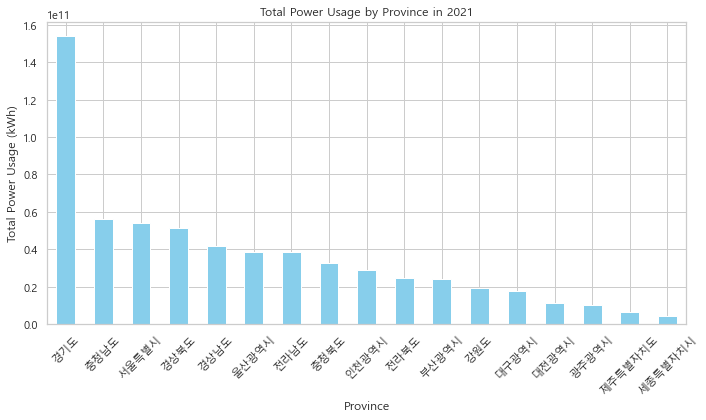

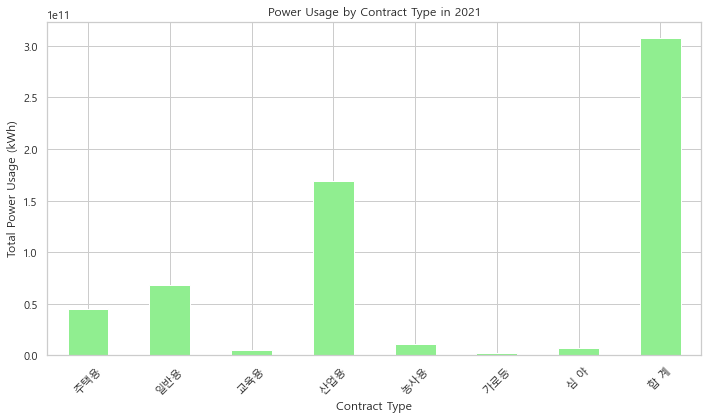

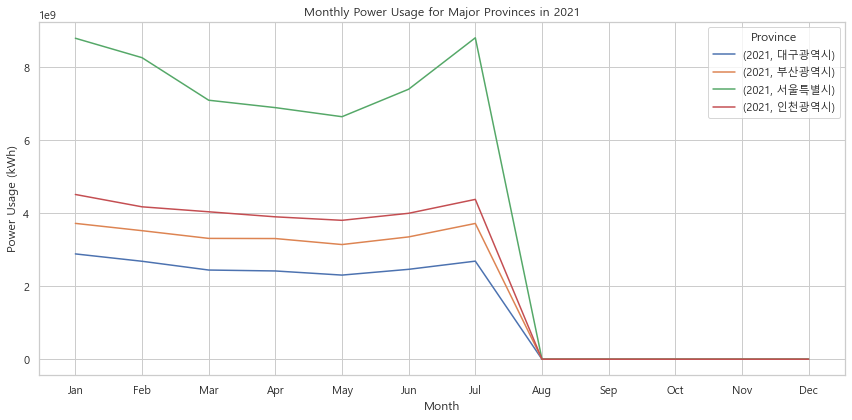

In [49]:
# Recreating the plots with the corrected data

# Plot 1: Total Power Usage by Province
plt.figure(figsize=(10, 6))
total_power_by_province_corrected.plot(kind='bar', color='skyblue')
plt.title('Total Power Usage by Province in 2021')
plt.xlabel('Province')
plt.ylabel('Total Power Usage (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Power Usage by Contract Type
plt.figure(figsize=(10, 6))
power_by_contract_type_corrected.plot(kind='bar', color='lightgreen')
plt.title('Power Usage by Contract Type in 2021')
plt.xlabel('Contract Type')
plt.ylabel('Total Power Usage (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Monthly Power Usage for Major Provinces
monthly_power_major_cities_corrected.T.plot(figsize=(12, 6))
plt.title('Monthly Power Usage for Major Provinces in 2021')
plt.xlabel('Month')
plt.ylabel('Power Usage (kWh)')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Province')
plt.tight_layout()
plt.show()

### 전력 사용량 지역 순위

1.경기도

2.충청남도

3.서울

### 전력 사용 유형

1.산업용

2.일반용

3.주택용

전력사용량은 겨울철과 여름철 사용량이 비슷하다